In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
# Behaves differently from MNIST / Fashion MNIST
# it is a Numpy array
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [4]:
# we are working with color images now
train_dataset.data.shape

(50000, 32, 32, 3)

In [6]:
# Behaves differently from MNIST / Fashion MNIST
# it is a list
train_dataset.targets[:5]

[6, 9, 9, 4, 1]

In [7]:
# number of classes
K = len(set(train_dataset.targets))
print(f'number of classes: {K}')

number of classes: 10


In [8]:
# Data loader
# Usefull because it automatically generates batches in the training loop
# and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [11]:
# the data transformer mapped the data to (0,1)
# and also moved the color channel before height/width
tmp_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True
)

for x,y in tmp_loader:
  print(x)
  print(x.shape)
  break

tensor([[[[0.3451, 0.4431, 0.3647,  ..., 0.7098, 0.6980, 0.6627],
          [0.2902, 0.6275, 0.5725,  ..., 0.7020, 0.6863, 0.6471],
          [0.4039, 0.6588, 0.5373,  ..., 0.6980, 0.6824, 0.6471],
          ...,
          [0.3490, 0.3569, 0.3765,  ..., 0.3098, 0.3216, 0.3333],
          [0.3686, 0.3765, 0.3804,  ..., 0.3137, 0.3216, 0.3333],
          [0.3804, 0.3804, 0.3647,  ..., 0.3294, 0.3373, 0.3451]],

         [[0.2588, 0.3451, 0.3098,  ..., 0.6235, 0.6118, 0.5725],
          [0.2471, 0.6118, 0.5137,  ..., 0.6157, 0.6000, 0.5608],
          [0.3608, 0.6314, 0.4431,  ..., 0.6118, 0.5961, 0.5608],
          ...,
          [0.3529, 0.3608, 0.3804,  ..., 0.3137, 0.3255, 0.3333],
          [0.3725, 0.3804, 0.3843,  ..., 0.3176, 0.3255, 0.3333],
          [0.3843, 0.3843, 0.3686,  ..., 0.3333, 0.3412, 0.3451]],

         [[0.1843, 0.2706, 0.2549,  ..., 0.6353, 0.6235, 0.5843],
          [0.2000, 0.5765, 0.4471,  ..., 0.6275, 0.6118, 0.5725],
          [0.3294, 0.6078, 0.3255,  ..., 0

In [12]:
# Define the model\
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    # define the conv layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
    # define the linear layers
    self.fc1 = nn.Linear(128 * 3 * 3, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = x.view(-1, 128 * 3 *3)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.5)
    x = self.fc2(x)
    return x

In [13]:
# Instantiate the model
model = CNN(K)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=1000):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zer0 the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    model.eval()

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")


  return train_losses, test_losses

In [17]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader,
                                     epochs=15)

Epoch 1/15, Train Loss: 1.7401, Test Loss: 1.4858, Duration: 0:00:14.417082
Epoch 2/15, Train Loss: 1.4377, Test Loss: 1.3539, Duration: 0:00:08.039646
Epoch 3/15, Train Loss: 1.3144, Test Loss: 1.3232, Duration: 0:00:11.382755
Epoch 4/15, Train Loss: 1.2367, Test Loss: 1.2196, Duration: 0:00:13.258516
Epoch 5/15, Train Loss: 1.1730, Test Loss: 1.1981, Duration: 0:00:08.014128
Epoch 6/15, Train Loss: 1.1218, Test Loss: 1.1943, Duration: 0:00:07.999801
Epoch 7/15, Train Loss: 1.0837, Test Loss: 1.1382, Duration: 0:00:08.006618
Epoch 8/15, Train Loss: 1.0433, Test Loss: 1.1127, Duration: 0:00:08.005496
Epoch 9/15, Train Loss: 1.0079, Test Loss: 1.0941, Duration: 0:00:10.198543
Epoch 10/15, Train Loss: 0.9747, Test Loss: 1.0791, Duration: 0:00:08.019378
Epoch 11/15, Train Loss: 0.9499, Test Loss: 1.0715, Duration: 0:00:08.063526
Epoch 12/15, Train Loss: 0.9232, Test Loss: 1.0686, Duration: 0:00:09.129954
Epoch 13/15, Train Loss: 0.9021, Test Loss: 1.0824, Duration: 0:00:07.991427
Epoch 14

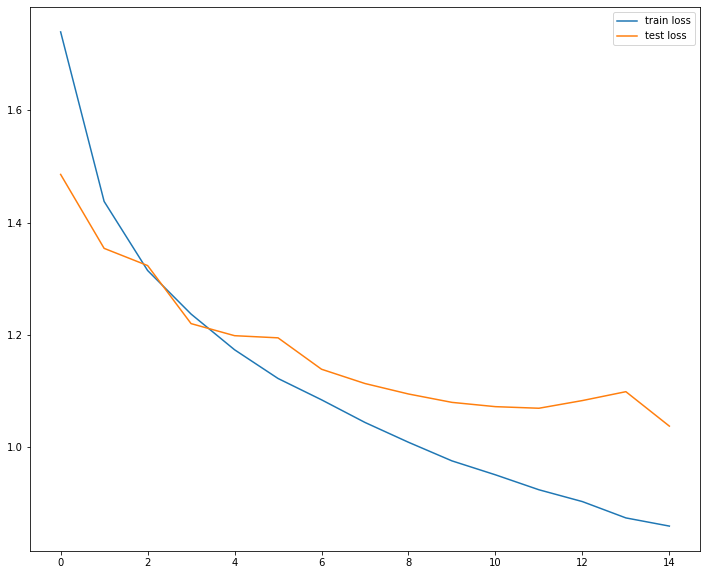

In [18]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [19]:
# Accuracy

model.eval()
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.7117, Test acc: 0.6367


In [20]:
from prompt_toolkit.layout.containers import HorizontalAlign
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(f"{cm}\n")
  plt.figure(figsize=(12,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[652  31  58  22  16  11  11  18 106  75]
 [ 13 744   5   9   1   9   7   7  30 175]
 [ 68  11 502  57  91  90  86  44  28  23]
 [ 20  19  87 407  59 225  79  45  19  40]
 [ 27   9  84  61 539  71  77 108  15   9]
 [ 10   6  59 178  43 582  34  55  14  19]
 [  4   6  61  81  33  28 740  12  10  25]
 [ 20   8  23  52  55  88  11 712   2  29]
 [ 68  46  17  13  10   6   6   8 773  53]
 [ 28  89   7  17   7  11   9  16  30 786]]



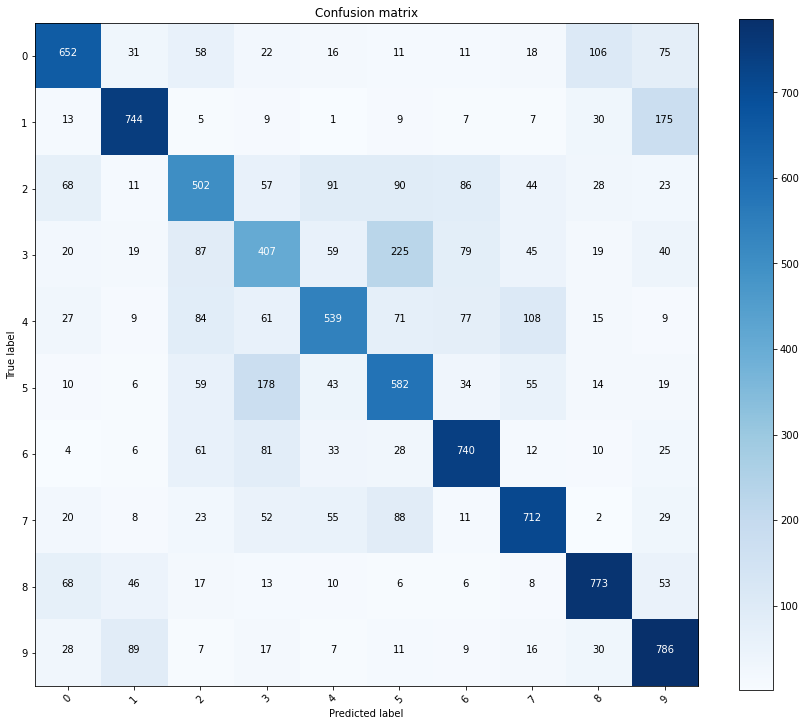

In [22]:
# Get all predictions in an array and plot confusiuon matrix

x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm,list(range(10)))

In [23]:
# Label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split('\n')
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Text(0.5, 1.0, 'True label: cat Predicted dog')

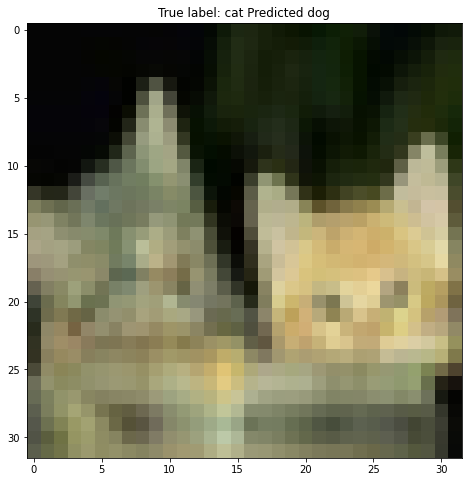

In [31]:
# show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassifed_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassifed_idx)
plt.figure(figsize=(8,8))
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted %s" % (labels[y_test[i]], labels[p_test[i]]))